In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics
from ast import literal_eval

# Gensim
from gensim.models import KeyedVectors

# Keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping

# TensorFlow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import legacy

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Membaca data
train_data = pd.read_csv('../../../../Data/5. Split/under/train_data_90_10_under.csv')
validation_data = pd.read_csv('../../../../Data/5. Split/under/validation_data_90_10_under.csv')
test_data = pd.read_csv('../../../../Data/5. Split/under/test_data_90_10_under.csv')

In [3]:
# Memisahkan fitur dan label untuk setiap bagian dataset
x_train = train_data['text_tokenize'].apply(literal_eval)
y_train = train_data.label

x_validation = validation_data['text_tokenize'].apply(literal_eval)
y_validation = validation_data.label

x_test = test_data['text_tokenize'].apply(literal_eval)
y_test = test_data.label

Word2Vec

In [4]:
# Memuat model Word2Vec CBOW yang telah disimpan
model_ug_cbow = KeyedVectors.load('../../../../Model/w2v_model_ug_cbow.word2vec')

# Memuat model Word2Vec Skip-gram yang telah disimpan
model_ug_sg = KeyedVectors.load('../../../../Model/w2v_model_ug_sg.word2vec')

In [5]:
# Menghitung jumlah kata unik dalam model Word2Vec CBOW
unique_words_count = len(model_ug_cbow.wv.index_to_key)

# Menampilkan jumlah kata unik
print(unique_words_count)

7349


In [6]:
embeddings_index = {}

# Menggabungkan kedua embeddings dari model CBOW dan Skip-gram untuk setiap kata unik
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])

# Menampilkan jumlah vektor kata yang ditemukan
print('Found %s word vectors.' % len(embeddings_index))

Found 7349 word vectors.


In [7]:
# Membuat tokenizer dengan jumlah kata maksimum 
tokenizer = Tokenizer(num_words=unique_words_count)  # num_words adalah jumlah kosakata yang ingin digunakan

# Melatih tokenizer pada teks dari data latih
tokenizer.fit_on_texts(x_train)

# Mengonversi teks menjadi urutan bilangan bulat yang merepresentasikan indeks kata
sequences = tokenizer.texts_to_sequences(x_train)

In [8]:
length = []

# Menghitung jumlah kata dalam setiap teks dari data latih (x_train) dan menyimpannya dalam daftar length
for x in x_train:
    length.append(len(x))

# length berisi panjang (jumlah kata) dari setiap teks dalam data latih

In [9]:
# Menghitung jumlah kata maksimum dalam satu kalimat dari data latih (x_train)
max_word_count = max(length)

# Menampilkan jumlah kata maksimum
print("Maximum number of words in a sentence:", max_word_count)

Maximum number of words in a sentence: 440


In [10]:
# Menetapkan panjang maksimum urutan (max_len) untuk padding
max_len = max_word_count

# max_len digunakan untuk membatasi panjang urutan maksimum saat melakukan padding

In [11]:
# Melakukan padding pada urutan data latih (x_train) agar memiliki panjang yang sama (max_len)
x_train_seq = pad_sequences(sequences, maxlen=max_len)

# Menampilkan bentuk tensor data latih yang telah dipad (x_train_seq)
print('Shape of padded data tensor:', x_train_seq.shape)

Shape of padded data tensor: (2446, 440)


In [12]:
# Mengonversi teks dalam data validation (x_validation) menjadi urutan angka menggunakan tokenizer yang sama
sequences_val = tokenizer.texts_to_sequences(x_validation)

# Melakukan padding pada urutan data validasi agar memiliki panjang yang sama (max_len)
x_validation_seq = pad_sequences(sequences_val, maxlen=max_len)

# Komentar: Sekarang, x_validation_seq berisi data validasi yang telah dipad dan siap digunakan

In [13]:
# Menetapkan jumlah kata yang akan digunakan dalam matriks embedding
num_words = len(tokenizer.word_index) + 1

# Membuat matriks embedding kosong dengan bentuk (num_words, 200)
embedding_matrix = np.zeros((num_words, 200))

# Mengisi matriks embedding dengan vektor embedding yang sesuai dari embeddings_index
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Komentar: embedding_matrix sekarang berisi vektor embedding untuk seluruh kata unik dalam tokenizer.word_index

In [14]:
# Ubah label menjadi one-hot encoding
y_train_cat = to_categorical(y_train + 1, num_classes=3)
y_validation_cat = to_categorical(y_validation + 1, num_classes=3)

Pemodelan CNN

In [15]:
# Setting learning rate within the Adam optimizer
Adam = legacy.Adam(learning_rate=0.001)

# Setting the label smoothing within the loss function
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Setting an Early_stopping callback to monitor accuracy with a patience degree of 3
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [16]:
# Membuat model Sequential
model_cnn = Sequential()

# Menambahkan layer Embedding
model_cnn.add(Embedding(num_words, 200, input_length=max_len))

# Menambahkan layer Conv1D
model_cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

# Menambahkan layer Conv1D
model_cnn.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

# Menambahkan layer GlobalMaxPooling1D
model_cnn.add(GlobalMaxPooling1D())

# Menambahkan layer Dense dengan aktivasi ReLU
model_cnn.add(Dense(256, activation='relu'))

# Menambahkan layer Dense output dengan aktivasi softmax untuk klasifikasi multi-kelas
model_cnn.add(Dense(3, activation='softmax'))

# Mengkompilasi model dengan fungsi loss 'categorical_crossentropy', optimizer 'adam', dan metrik evaluasi 'accuracy'
model_cnn.compile(loss=loss, optimizer=Adam, metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 440, 200)          960600    
                                                                 
 conv1d (Conv1D)             (None, 440, 32)           19232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 220, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 220, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 110, 64)          0         
 1D)                                                             
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0

In [17]:
# Melatih model menggunakan data latihan dan validasi
history_model = model_cnn.fit(x_train_seq, y_train_cat, validation_data=(x_validation_seq, y_validation_cat), epochs=10, batch_size=128, callbacks=[callback], verbose=2)

Epoch 1/10
20/20 - 3s - loss: 1.0917 - accuracy: 0.4227 - val_loss: 1.0633 - val_accuracy: 0.5294 - 3s/epoch - 165ms/step
Epoch 2/10
20/20 - 3s - loss: 0.9528 - accuracy: 0.6823 - val_loss: 0.8472 - val_accuracy: 0.6397 - 3s/epoch - 126ms/step
Epoch 3/10
20/20 - 2s - loss: 0.6746 - accuracy: 0.7964 - val_loss: 0.7675 - val_accuracy: 0.7206 - 2s/epoch - 121ms/step
Epoch 4/10
20/20 - 2s - loss: 0.4916 - accuracy: 0.9072 - val_loss: 0.8052 - val_accuracy: 0.7206 - 2s/epoch - 104ms/step
Epoch 5/10
20/20 - 2s - loss: 0.3870 - accuracy: 0.9734 - val_loss: 0.8222 - val_accuracy: 0.7426 - 2s/epoch - 106ms/step
Epoch 6/10
20/20 - 2s - loss: 0.3392 - accuracy: 0.9902 - val_loss: 0.8156 - val_accuracy: 0.7279 - 2s/epoch - 104ms/step
Epoch 7/10
20/20 - 2s - loss: 0.3174 - accuracy: 0.9980 - val_loss: 0.8144 - val_accuracy: 0.7500 - 2s/epoch - 105ms/step
Epoch 8/10
20/20 - 2s - loss: 0.3083 - accuracy: 0.9984 - val_loss: 0.8454 - val_accuracy: 0.7206 - 2s/epoch - 104ms/step
Epoch 9/10
20/20 - 2s - 

Evaluasi Pemodelan CNN

In [18]:
model_eval = model_cnn.evaluate(x_validation_seq, y_validation_cat, verbose=0)
print("Akurasi validasi model eksperimen 1: {:.2f}%".format(model_eval[1] * 100))

Akurasi validasi model eksperimen 1: 75.00%


In [22]:
# Mengkonversi teks dalam x_test menjadi urutan token dengan tokenizer
sequences_test = tokenizer.texts_to_sequences(x_test)

# Melakukan padding pada urutan token agar memiliki panjang yang sama
x_test_seq = pad_sequences(sequences_test, maxlen=max_len)

# Mengubah label y_test menjadi bentuk one-hot encoding
y_test_cat = to_categorical(y_test + 1, num_classes=3) 

In [23]:
# Menilai model CNN yang telah dilatih menggunakan data test (x_test_seq dan y_test_cat)
CNN_model_evaluation = model_cnn.evaluate(x=x_test_seq, y=y_test_cat)

# Memprediksi label kelas menggunakan model CNN yang telah dilatih pada data test (x_test_seq)
yhat_cnn = model_cnn.predict(x_test_seq)

5/5 [==============================] - 0s 8ms/step


In [24]:
# Mengkonversi prediksi probabilitas ke label kelas untuk kedua model
y_pred_cnn = np.argmax(yhat_cnn, axis=1) - 1

# Menghitung true label dari one-hot encoding
y_true = np.argmax(y_test_cat, axis=1) - 1

In [25]:
# Menampilkan classification report untuk kedua model
print("Classification Report (CNN Model):")
print(classification_report(y_true, y_pred_cnn))

Classification Report (CNN Model):
              precision    recall  f1-score   support

          -1       0.79      0.76      0.77        45
           0       0.74      0.67      0.70        46
           1       0.75      0.84      0.79        45

    accuracy                           0.76       136
   macro avg       0.76      0.76      0.76       136
weighted avg       0.76      0.76      0.76       136



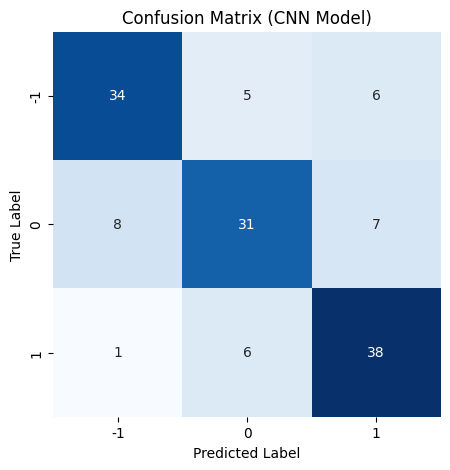

In [27]:
# Fungsi untuk visualisasi confusion matrix
def plot_cm(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.yticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Menampilkan visualisasi confusion matrix untuk kedua model
plot_cm(cm_cnn, "Confusion Matrix (CNN Model)")

Output

In [29]:
# Panggil dataset
full_data = pd.read_csv('../../../../Data/3. EDA/clean-eda_.csv')

# Prediksi pada keseluruhan data
sequences_full = tokenizer.texts_to_sequences(full_data['text'])
x_full_seq = pad_sequences(sequences_full, maxlen=max_len)
yhat_full_cnn= model_cnn.predict(x_full_seq)

# Konversi prediksi ke label kelas
yhat_full_cnn_classes = np.argmax(yhat_full_cnn, axis=1) - 1

# Tambahkan kolom baru ke DataFrame
full_data['predicted_sentiment'] = yhat_full_cnn_classes

full_data.head(10)

150/150 [==============================] - 1s 7ms/step


,video_id,raw,text,predicted_sentiment
0,video1,Baiknya bagaimana menurut kalian?,baik bagaimana turut kalian,0
1,video1,Betul dok betul dok,betul dok betul dok,0
2,video1,Betul dok mungkin efek sa di,betul dok mungkin efek sa,0
3,video1,"Bpom aneh, tidak kerja. Kenapa ko seperti itu.",bpom aneh kerja kok itu,-1
4,video1,Benar banget anak sy aj hrs sirup minum obatny...,benar banget anak aku saja harus sirup minum o...,0
5,video1,Makasih ilmunya dokter semoga berkah🥰🥰🥰🥰,terima kasih ilmu dokter semoga berkah,1
6,video1,Dok tempra gimana? Soalnya anakku kalau demam ...,dok tempra bagaimana soal anak kalau demam kas...,0
7,video1,BIOSOLFON KIDS AMAN GAK KAK,biosolfon kids aman enggak kak,0
8,video1,apa kurang ilmu ya dok,apa kurang ilmu dok,0
9,video1,Cara media massa cari uang.... Memainkan keres...,cara media massa cari uang main resah bingung ...,-1


In [30]:
#full_data.to_csv("./../../Data/6. Prediksi/submission-CNN.csv", index=False)